# Regression - Housing Price Prediction

In [67]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
import lightgbm as lgb 
from sklearn import pipeline
from sklearn import model_selection 
from sklearn import metrics
from sklearn import preprocessing 
from sklearn import compose
from yellowbrick.regressor import *
from yellowbrick.classifier import * 
train = pd.read_csv('./data/train.csv').set_index('Id')
test = pd.read_csv('./data/test.csv').set_index('Id')

# Grab Column Dtypes

In [68]:
numeric_ = train.select_dtypes(['int','float']).columns
object_ = train.select_dtypes(['O']).columns
train['LogPrice'] = train['SalePrice'].apply(np.log1p)

# EDA

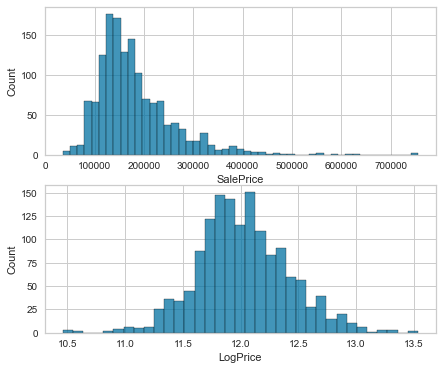

In [69]:
fig,axs=plt.subplots(2,1, figsize=(7,6))
sns.histplot(train['SalePrice'],ax=axs[0])
sns.histplot(train['LogPrice'], ax=axs[1])
train['SalePrice'] = train['LogPrice']
train.drop(columns=['LogPrice'],inplace=True)

# Data Transform Pipe

In [70]:
cat_transform = compose.ColumnTransformer(transformers=[
    ('ohe', preprocessing.OneHotEncoder(handle_unknown='ignore'), object_)]
                                          ,remainder='passthrough',verbose_feature_names_out=False)
m = lgb.LGBMRegressor()
pipe = pipeline.Pipeline(steps=[
            ('ohe',cat_transform),
            ('m', m)])

In [73]:
X = train.drop(columns=['SalePrice'])
y = train['SalePrice']
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=.2, random_state=0)
cv = model_selection.KFold(n_splits=100, shuffle=True, random_state=1)
scores = model_selection.cross_val_score(pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, verbose=1)
abs(scores)
print(f'Mean:{abs(scores.mean()):.2}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean:0.018


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.6s finished


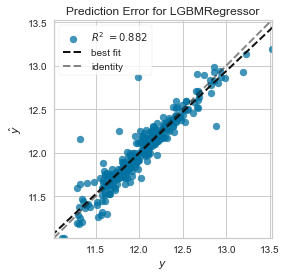

<AxesSubplot:title={'center':'Prediction Error for LGBMRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [52]:
m = pipe.fit(X_train,y_train)
preds = np.exp(m.predict(X_test))
vis = PredictionError(m)
vis.fit(X_train,y_train)
vis.score(X_test,y_test)
vis.show()

In [53]:
m = pipe.fit(X,y)
preds = np.exp(m.predict(test))
test['SalePrice'] = preds
test['SalePrice'].to_csv("preds.csv")

<AxesSubplot:>

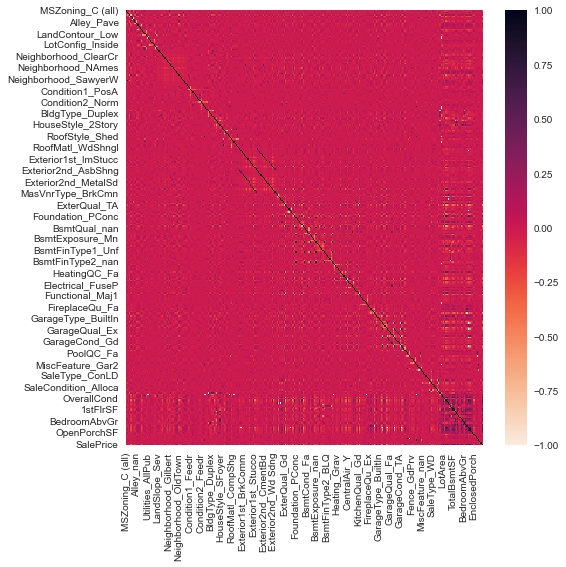

In [72]:
fig,axs=plt.subplots(1,figsize=(8,8))
sns.heatmap(pd.DataFrame(cat_transform.fit_transform(train).todense(), columns=cat_transform.get_feature_names_out()).corr(method='pearson'),
            cmap='rocket_r')

# Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

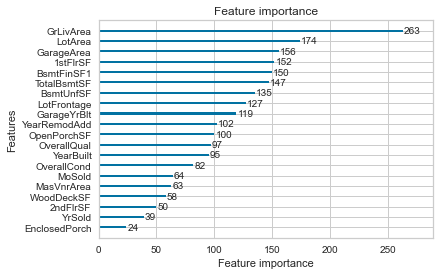

In [55]:
z = pd.DataFrame(cat_transform.fit_transform(X_train).todense(), 
            columns=cat_transform.get_feature_names_out())

m = lgb.LGBMRegressor()
m.fit(z, y_train)
lgb.plot_importance(m,max_num_features=20)

# Multi-Class Classifier

In [56]:
copy = train.copy()
copy['target'] = pd.qcut(x=copy['SalePrice'],q=4, precision=1)
mapping = dict(enumerate(copy['target'].cat.categories ) )
copy['target'] = copy['target'].cat.codes
X_train,X_test,y_train,y_test = model_selection.train_test_split(copy.drop(columns=['target','SalePrice']), copy['target'])

In [57]:
X_train = cat_transform.transform(X_train)
X_test = cat_transform.transform(X_test)

In [58]:
m = lgb.LGBMClassifier()
m.fit(X_train,y_train)
preds = m.predict(X_test)

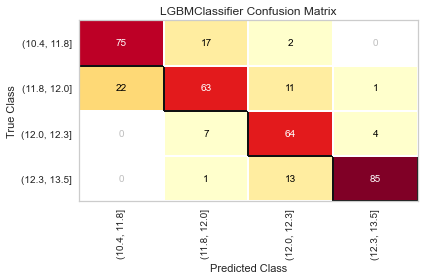

<AxesSubplot:title={'center':'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [59]:
c = [str(mapping[x]) for x in mapping.keys()]
vis = ConfusionMatrix(m, classes=c)
vis.fit(X_train,y_train)
vis.score(X_test,y_test)
vis.show()

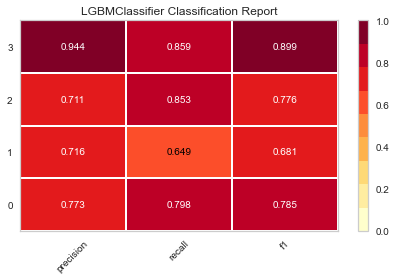

<AxesSubplot:title={'center':'LGBMClassifier Classification Report'}>

In [60]:
vis = ClassificationReport(m, classies=[0,1,2,3])
vis.fit(X_train,y_train)
vis.score(X_test,y_test)
vis.show()

**CV**

In [61]:
p=pipeline.Pipeline(steps=[
    ('ohe',cat_transform),
    ('m', lgb.LGBMClassifier())
])

In [62]:
X_train,X_test,y_train,y_test=model_selection.train_test_split(copy.drop(columns=['SalePrice','target']), copy['target'], test_size=.3)

- Micro for class imbalance. Since our classes are evenly distr. we will use macro.

In [66]:
cv = model_selection.KFold(n_splits=100, shuffle=True, random_state=1)
scores = model_selection.cross_val_score(p, X_train,y_train, scoring='f1_macro', cv=cv, verbose=1)
print(f'Mean:{abs(scores.mean())}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean:0.7135318015318013


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   29.3s finished
